# Logits to Normal Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
from functools import reduce
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax
from sklearn import datasets

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer, PlanarLayer

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
n_samples = 5000
dim = 3

PI = torch.Tensor([math.pi])

In [4]:
def create_animation_logits(intermediate_results):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    
    return ani

In [5]:
def create_animation_simplex(intermediate_results):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        probs = softmax(intermediate_results[i], 1)
        for j, collection in enumerate(ax.ax.collections):
            collection.set_offsets(np.array(project_sequence(probs[target==j])).T)
        ax._redraw_labels()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

## Base distribution, Uncalibrated Logits

In [6]:
target = np.array(random.choices(range(3), k=n_samples))
one_hot = np.zeros((n_samples, 3))
one_hot[np.arange(n_samples), target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

logits = np.float32(0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
logits -= np.log(np.sum(np.exp(logits), axis=1, keepdims=True))

probs = softmax(logits, axis=1)

# Convert data to torch tensors.
torch_logits = torch.as_tensor(logits, dtype=torch.float)
torch_target = torch.as_tensor(target, dtype=torch.long)


In [7]:
def nll(probs):
    return np.mean(-np.log(probs[np.arange(probs.shape[0]), target]))

In [8]:
# Uncalibrated NLL
print(nll(probs))

0.8234918


## Define Flows

In [223]:
class GaussianizatioFlow(nn.Module):
    
    def __init__(self, dim, K=1):
        
        super(GaussianizatioFlow, self).__init__()
        
        self.invertible=True
        self.dim = dim
        self.K = K
        
        self.vs = nn.ParameterList(nn.Parameter(torch.randn(dim, 1, requires_grad=True))
                                   for i in range(dim))
        self.mus = nn.Parameter(torch.randn(1, dim, K, requires_grad=True)*0.01)
        self.hs = nn.Parameter(torch.randn(1, dim, K, requires_grad=True)*0.01 + 1.)
        
        
    def computeR(self):
        Hs = [torch.eye(self.dim) - 2*torch.mm(v, v.view(1, -1))/torch.mm(v.view(1, -1), v) for v in self.vs]
        R = reduce(lambda A, B: torch.mm(A, B), Hs, torch.eye(self.dim))
        
        return R
                                
        
    def forward(self, x):
        
        # Rotation
        R = self.computeR()
        x = torch.mm(x, R)
        
        # Non-linearity
        scaled = (x[:, :, None] - self.mus)/self.hs
        
        print('###########')
        print(x[:3])
        print(self.mus)
        print(self.hs)
        print(scaled[:3])
        print('.-.-.-.-.-.-')
        
        sig = torch.sigmoid(scaled)
        
        print(sig[:3])
        
        F = torch.sum(torch.sigmoid(scaled), dim=2)/self.K
        z = np.sqrt(2)*torch.erfinv(2*F - 1.0)
        
        print(z[:3])
        
        print('###########')
        
        
        log_det = -0.5*(self.dim*torch.log(2*PI) + torch.sum(z**2, dim=1)) \
            + torch.sum(torch.log(torch.abs(F*(1/self.K - F))), dim=1) \
            + self.dim*torch.log(torch.abs(torch.sum(1/self.hs)))
        
        return z, log_det
    
    
    def backward(self, z):
        
        # Non-linearity
        scaled = (z[:, :, None] - self.mus)/self.hs
        
        print('#**********#')
        print(z[:3])
        print(self.mus)
        print(self.hs)
        print(scaled[:3])
        print('.-.-.-.-.-.-')
        
        exp_s = torch.exp(-scaled)
        
        print(exp_s[:3])
        print(((1 + exp_s)**2)[:3])
        print((self.hs*(1 + exp_s)**2)[:3])
        
        x = torch.sum(exp_s/(self.hs*(1 + exp_s)**2), dim=2)/self.K
        
        print(x[:3])
        
        # Rotation
        R = self.computeR()
        x = torch.mm(x, R.T)
        print(x[:3])
        
        print('#*********#')
        log_det = 0.0
        
        return x, log_det

## Create flow

In [16]:
model = Flow(layers=[GaussianizatioFlow(dim, K=1) for _ in range(5)])
dev = torch.device('cpu')

## Train flow

In [84]:
epochs = 40000

In [85]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss = []
logpz = []
logdet = []

intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model(torch_logits)
    
    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(-0.5 * (torch.log(2*PI)*dim + torch.sum(preds[-1]**2, dim=1)))
    _loss = -_logpz - _logdet

    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")
        intermediate_results.append(preds[-1].detach().numpy())

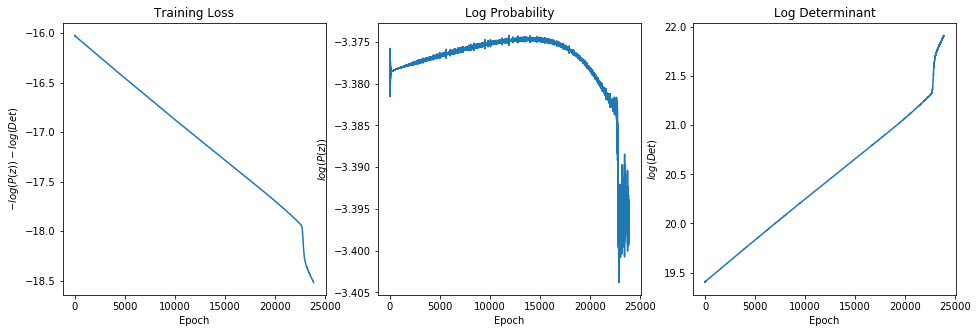

In [86]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss)
ax[1].plot(logpz)
ax[2].plot(logdet)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

In [87]:
model.layers[2].hs

Parameter containing:
tensor([[[nan],
         [nan],
         [nan]]], requires_grad=True)

In [88]:
Q = model.layers[2].computeR().detach().cpu().numpy()
a = np.array([1, 3.5, 3])

a@Q@Q.T

array([nan, nan, nan])

### GIF animation

In [89]:
preds, _ = model(torch_logits)
preds = preds[-1].detach().numpy()

print(nll(softmax(preds, 1)))

nan


In [90]:
preds

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

In [80]:
ani = create_animation_simplex(intermediate_results)

In [81]:
HTML(ani.to_html5_video())

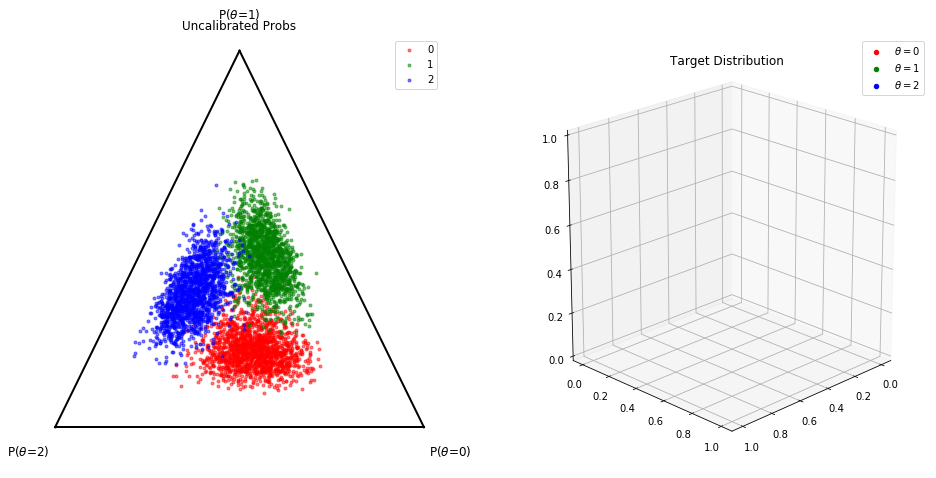

In [91]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(20, 45)

colors = ['r', 'g', 'b']
ax1 = plot_prob_simplex(probs, target, ax=ax1, title='Simulated Probabilities')
for i in range(3):
    ix = target==i
    ax2.scatter(preds[ix, 0], preds[ix, 1], preds[ix, 2], c=colors[i], label=r'$\theta={}$'.format(i))

    
ax1.set_title('Uncalibrated Probs')
ax2.set_title('Target Distribution')
ax2.legend()
plt.show()

## Estimated pdf of each dimension

C:\Users\sergi\Anaconda3\envs\calibration\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\sergi\Anaconda3\envs\calibration\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\sergi\Anaconda3\envs\calibration\lib\site-packages\numpy\lib\histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


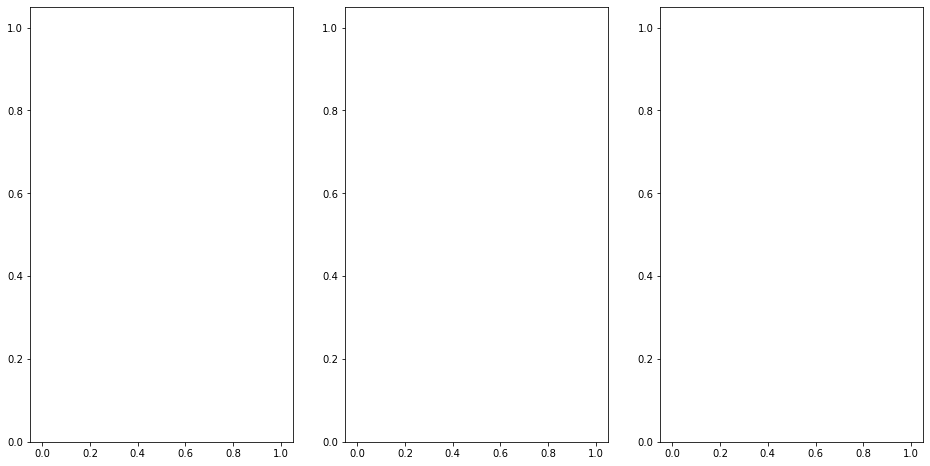

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

ax[0].hist(preds[:, 0], 100, range=[-3, 3], density=True)

ax[1].hist(preds[:, 1], 100, range=[-3, 3], density=True)

ax[2].hist(preds[:, 2], 100, range=[-3, 3], density=True)

plt.show()

## Moons dataset

In [168]:
data = datasets.make_moons(n_samples=n_samples, noise=0.05)[0].astype(np.float32)
dim = 2
torch_data = torch.as_tensor(data, dtype=torch.float)

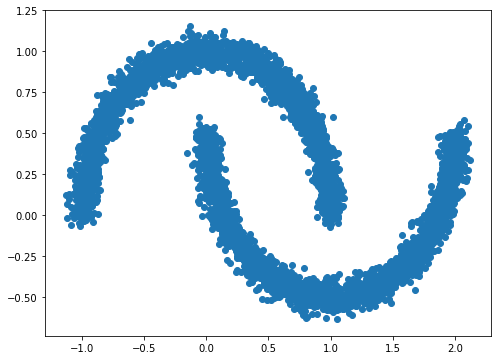

In [169]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(data[:, 0], data[:, 1])
plt.show()

In [224]:
# Flow
model = Flow(layers=[GaussianizatioFlow(dim, K=1) for _ in range(5)])

In [174]:
epochs = 1000

In [157]:
model = model.to(dev, non_blocking=True)

# Instantiate optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss = []
logpz = []
logdet = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = torch.zeros(1, device=dev)
    cum_logdet = torch.zeros(1, device=dev)
    cum_logprior = torch.zeros(1, device=dev)

    optimizer.zero_grad()

    preds, _logdet = model(torch_data)

    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(-0.5 * (torch.log(2*PI)*dim + torch.sum(preds[-1]**2, dim=1)))
    _loss = -_logpz - _logdet

    _loss.backward()
    optimizer.step()

    loss.append(_loss.item())
    logpz.append(_logpz.item())
    logdet.append(_logdet.item())

    if e%10 == 9:
        print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")

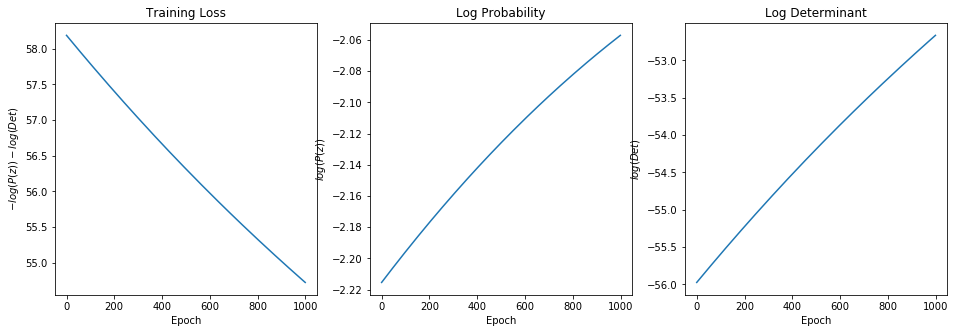

In [158]:
# Plot training NLL
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(loss)
ax[1].plot(logpz)
ax[2].plot(logdet)


ax[0].set_title('Training Loss')
ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
ax[0].set_xlabel('Epoch')

ax[1].set_title('Log Probability')
ax[1].set_ylabel(r'$log(P(z))$')
ax[1].set_xlabel('Epoch')

ax[2].set_title('Log Determinant')
ax[2].set_ylabel(r'$log(Det)$')
ax[2].set_xlabel('Epoch')

plt.show()

In [159]:
target = model(torch_data)[0][-1].detach().numpy()

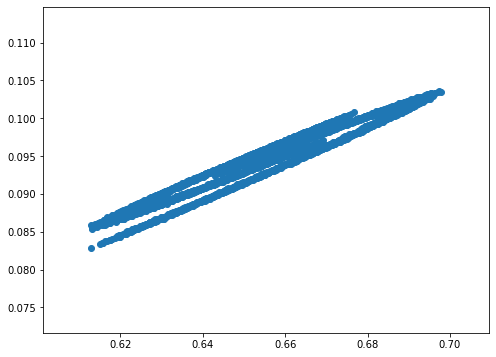

In [160]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(target[:, 0], target[:, 1])
plt.show()

In [161]:
base, _ = model.backward(torch.randn(100, dim))

In [162]:
base = base[-1].detach().numpy()

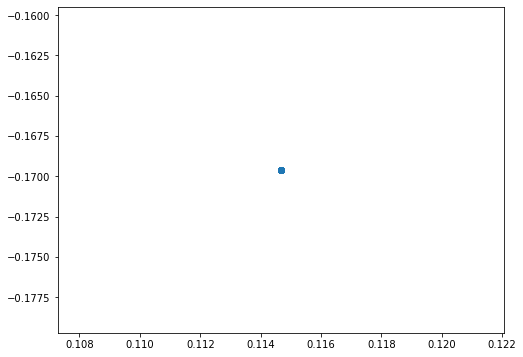

In [163]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(base[:, 0], base[:, 1])
plt.show()

In [225]:
torch_data_recon, _ = model.backward(model(torch_data)[0][-1])

###########
tensor([[ 0.1927, -1.2541],
        [ 0.0092, -0.0099],
        [ 0.6837,  0.8554]], grad_fn=<SliceBackward>)
Parameter containing:
tensor([[[-0.0099],
         [ 0.0037]]], requires_grad=True)
Parameter containing:
tensor([[[0.9953],
         [0.9913]]], requires_grad=True)
tensor([[[ 0.2036],
         [-1.2689]],

        [[ 0.0192],
         [-0.0138]],

        [[ 0.6970],
         [ 0.8592]]], grad_fn=<SliceBackward>)
.-.-.-.-.-.-
tensor([[[0.5507],
         [0.2194]],

        [[0.5048],
         [0.4966]],

        [[0.6675],
         [0.7025]]], grad_fn=<SliceBackward>)
tensor([[ 0.1275, -0.7741],
        [ 0.0120, -0.0086],
        [ 0.4331,  0.5316]], grad_fn=<SliceBackward>)
###########
###########
tensor([[ 0.4787,  0.6215],
        [-0.0019,  0.0147],
        [-0.6841, -0.0464]], grad_fn=<SliceBackward>)
Parameter containing:
tensor([[[-0.0042],
         [-0.0098]]], requires_grad=True)
Parameter containing:
tensor([[[1.0139],
         [1.0095]]], requires_grad

In [226]:
torch_data_recon[-1]

tensor([[-0.0817,  0.3409],
        [-0.0817,  0.3409],
        [-0.0817,  0.3409],
        ...,
        [-0.0817,  0.3409],
        [-0.0817,  0.3409],
        [-0.0817,  0.3409]], grad_fn=<MmBackward>)

In [227]:
torch_data

tensor([[ 1.1761, -0.4761],
        [ 0.0132,  0.0028],
        [-0.3851,  1.0251],
        ...,
        [-0.3774,  0.9224],
        [-0.6942,  0.7527],
        [ 0.2749, -0.2004]])